2022-07-10 09:20:53,381 - PySpice.Spice.NgSpice.Shared.NgSpiceShared._init_ngspice - WARNING - Unsupported Ngspice version 37


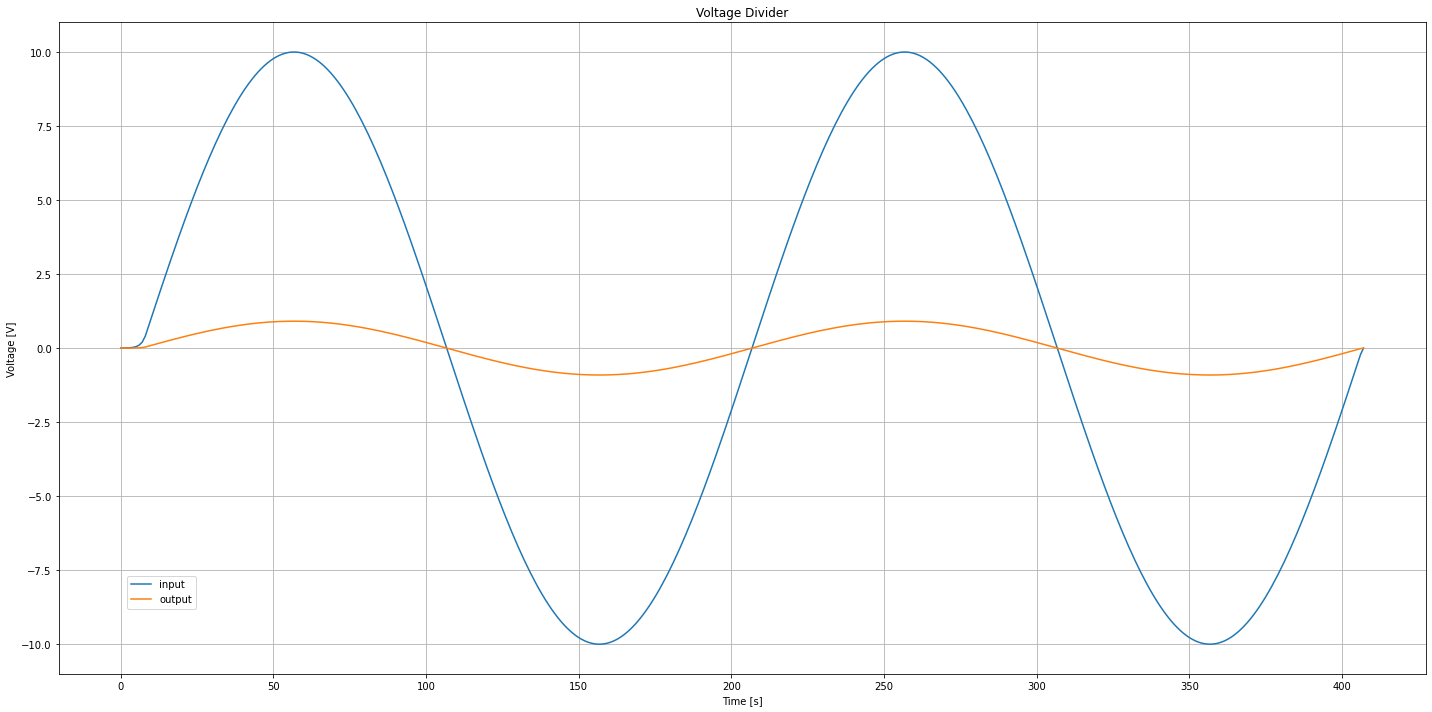

In [1]:
import math

import matplotlib.pyplot as plt


import PySpice.Logging.Logging as Logging
logger = Logging.setup_logging()


from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.NgSpice.Shared import NgSpiceShared
from PySpice.Unit import *


class MyNgSpiceShared(NgSpiceShared):


    def __init__(self, amplitude, frequency, **kwargs):

        super().__init__(**kwargs)

        self._amplitude = amplitude
        self._pulsation = float(frequency.pulsation)


    def get_vsrc_data(self, voltage, time, node, ngspice_id):
        self._logger.debug('ngspice_id-{} get_vsrc_data @{} node {}'.format(ngspice_id, time, node))
        voltage[0] = self._amplitude * math.sin(self._pulsation * time)
        return 0


    def get_isrc_data(self, current, time, node, ngspice_id):
        self._logger.debug('ngspice_id-{} get_isrc_data @{} node {}'.format(ngspice_id, time, node))
        current[0] = 1.
        return 0


circuit = Circuit('Voltage Divider')

circuit.V('input', 'input', circuit.gnd, 'dc 0 external')
circuit.R(1, 'input', 'output', 10@u_kΩ)
circuit.R(2, 'output', circuit.gnd, 1@u_kΩ)

amplitude = 10@u_V
frequency = 50@u_Hz
ngspice_shared = MyNgSpiceShared(amplitude=amplitude, frequency=frequency, send_data=False)
simulator = circuit.simulator(temperature=25, nominal_temperature=25,
                              simulator='ngspice-shared', ngspice_shared=ngspice_shared)
period = float(frequency.period)
analysis = simulator.transient(step_time=period/200, end_time=period*2)


figure1, ax = plt.subplots(figsize=(20, 10))
ax.set_title('Voltage Divider')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Voltage [V]')
ax.grid()
ax.plot(analysis.input)
ax.plot(analysis.output)
ax.legend(('input', 'output'), loc=(.05,.1))
ax.set_ylim(float(-amplitude*1.1), float(amplitude*1.1))

plt.tight_layout()
plt.show()